#PLN com análise de sentimento para classificação de críticas cinematográficas

##Bibliotecas

In [26]:
#!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 23.4 MB/s 


In [57]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import nltk
from nltk import tokenize
from nltk import ngrams
nltk.download(['stopwords', 'rslp'])
from string import punctuation
import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


##Dataset

In [2]:
resenha = pd.read_csv("imdb-reviews-pt-br.csv")

In [3]:
resenha.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In [4]:
classificacao = resenha['sentiment'].replace(['neg', 'pos'], [0,1])

In [5]:
resenha['classificacao'] = classificacao

##Criando Modelo

In [6]:
def classificar_texto(texto, coluna_texto, coluna_classificacao):
  vetorizar = CountVectorizer(lowercase=False, max_features=50)
  bag_of_words = vetorizar.fit_transform(texto[coluna_texto])
  treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words, 
                                                                texto[coluna_classificacao], 
                                                                random_state=42)

  regressao_logistica = LogisticRegression(solver='lbfgs')
  regressao_logistica.fit(treino, classe_treino)
  return regressao_logistica.score(teste, classe_teste)
print(classificar_texto(resenha, "text_pt", "classificacao"))

0.6583097452486858


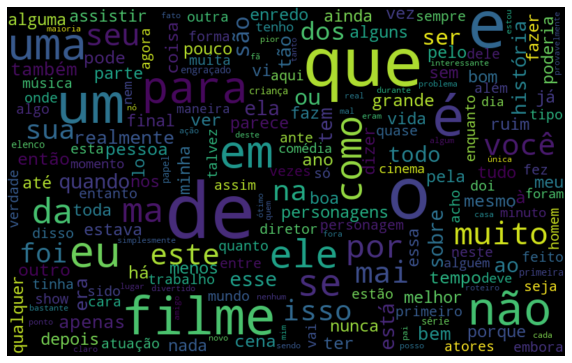

In [7]:
todas_palavras = ' '.join([texto for texto in resenha.text_pt])

nuvem_palavra = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras)

plt.figure(figsize=(10,7))
plt.imshow(nuvem_palavra, interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
def nuvem_palavras_pos(texto, coluna_texto):
  texto_positivo = texto.query("sentiment == 'pos'")
  todas_palavras = ' '.join([texto for texto in texto_positivo[coluna_texto]])

  nuvem_palavra = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras)

  plt.figure(figsize=(10,7))
  plt.imshow(nuvem_palavra, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [9]:
def nuvem_palavras_neg(texto, coluna_texto):
  texto_negativo = texto.query("sentiment == 'neg'")
  todas_palavras = ' '.join([texto for texto in texto_negativo[coluna_texto]])

  nuvem_palavra = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras)

  plt.figure(figsize=(10,7))
  plt.imshow(nuvem_palavra, interpolation='bilinear')
  plt.axis("off")
  plt.show()

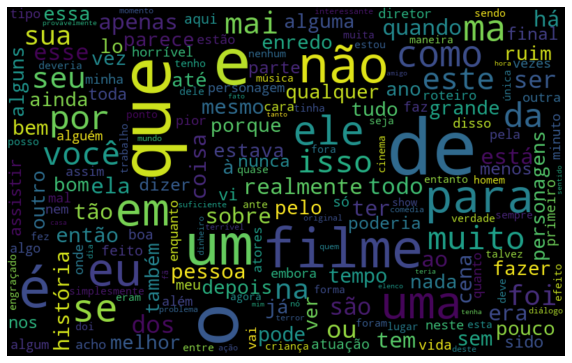

In [10]:
nuvem_palavras_neg(resenha, "text_pt")

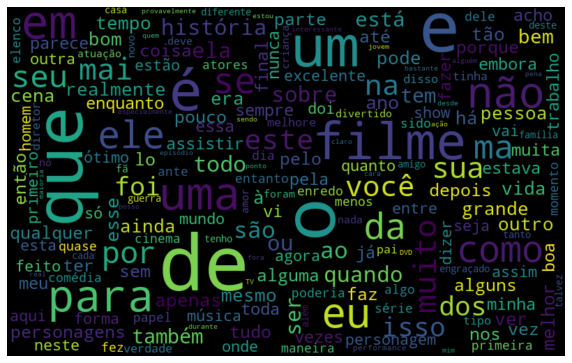

In [11]:
nuvem_palavras_pos(resenha, "text_pt")

In [12]:
token_espaco = tokenize.WhitespaceTokenizer()
token_frase = token_espaco.tokenize(todas_palavras)
frequencia = nltk.FreqDist(token_frase)
df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                              "Frequência": list(frequencia.values())})

In [13]:
df_frequencia.nlargest(columns="Frequência", n=10)

,Palavra,Frequência
20,de,417651
14,que,325070
42,e,299743
3,o,244881
7,um,216410
102,a,210179
45,é,192381
200,em,132778
1,uma,130888
29,não,127915


In [14]:
def pareto(texto, coluna_texto, quantidade):
  todas_palavras = ' '.join([texto for texto in texto[coluna_texto]])
  token_frase = token_espaco.tokenize(todas_palavras)
  frequencia = nltk.FreqDist(token_frase)
  df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                "Frequência": list(frequencia.values())})
  df_frequencia = df_frequencia.nlargest(columns="Frequência", n=quantidade)
  plt.figure(figsize=(12,8))
  ax = sns.barplot(data=df_frequencia, x="Palavra", y="Frequência", color="gray")
  ax.set(ylabel="Contagem")
  plt.show()

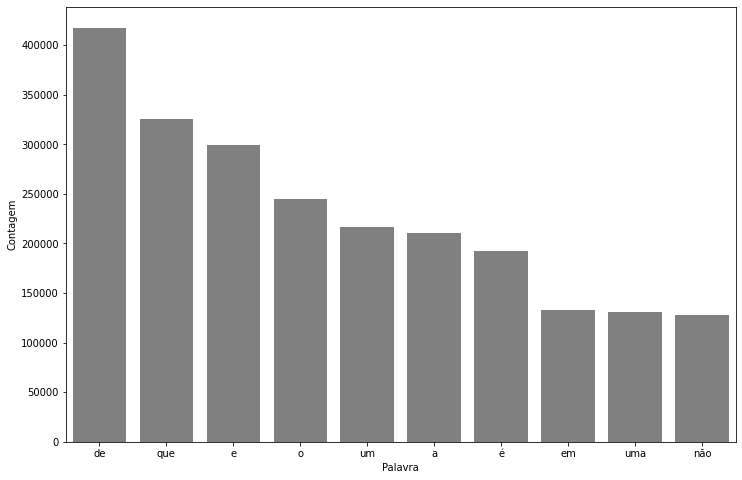

In [15]:
pareto(resenha, "text_pt", 10)

In [16]:
palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")

frase_processada = list()

for opiniao in resenha.text_pt:
  nova_frase = list()
  palavra_texto = token_espaco.tokenize(opiniao)
  for palavra in palavra_texto:
    if palavra not in palavras_irrelevantes:
      nova_frase.append(palavra)
  frase_processada.append(' '.join(nova_frase))

resenha["tratamento_1"] = frase_processada

In [17]:
classificar_texto(resenha, "tratamento_1", "classificacao")

0.6811160533764659

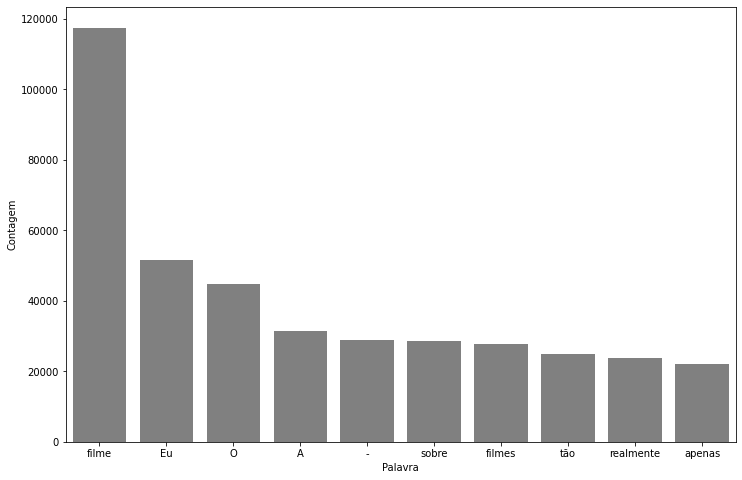

In [18]:
pareto(resenha, "tratamento_1", 10)

In [22]:
#Retirando a pontuação das palavras analisadas
token_pontuacao = tokenize.WordPunctTokenizer()
pontuacao = list()
for ponto in punctuation:
  pontuacao.append(ponto)

pontuacao_stopwords = pontuacao + palavras_irrelevantes

frase_processada = list()
for opiniao in resenha['tratamento_1']:
  nova_frase = list()
  palavras_texto = token_pontuacao.tokenize(opiniao)
  for palavra in palavras_texto:
    if palavra not in pontuacao_stopwords:
      nova_frase.append(palavra)
  frase_processada.append(' '.join(nova_frase))

resenha['tratamento_2'] = frase_processada

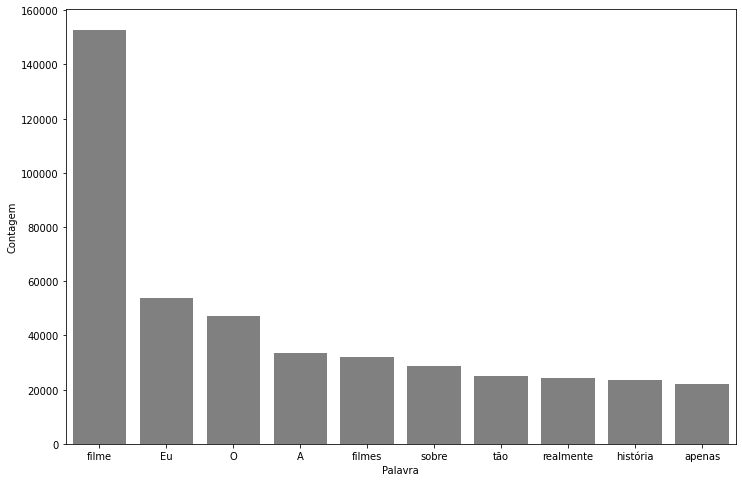

In [23]:
pareto(resenha, 'tratamento_2', 10)

In [30]:
#Tirando os acentos das palavras
sem_acentos = [unidecode.unidecode(texto) for texto in resenha['tratamento_2']]
stopwords_sem_acento = [unidecode.unidecode(texto) for texto in pontuacao_stopwords]

In [31]:
resenha['tratamento_3'] = sem_acentos

frase_processada = list()
for opiniao in resenha['tratamento_3']:
  nova_frase = list()
  palavras_texto = token_pontuacao.tokenize(opiniao)
  for palavra in palavras_texto:
    if palavra not in pontuacao_stopwords:
      nova_frase.append(palavra)
  frase_processada.append(' '.join(nova_frase))

resenha['tratamento_3'] = frase_processada

In [32]:
acuracia_tratamento3 = classificar_texto(resenha, 'tratamento_3', 'classificacao')
print(acuracia_tratamento3)

0.6887990295188031


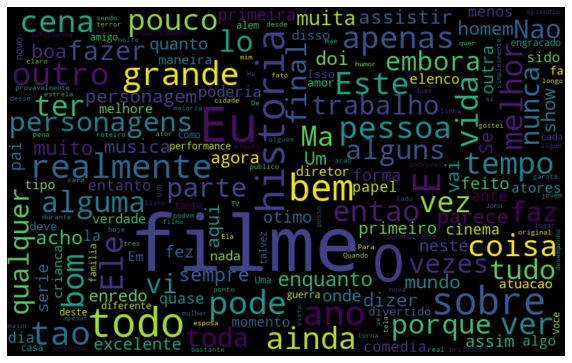

In [33]:
nuvem_palavras_pos(resenha, 'tratamento_3')

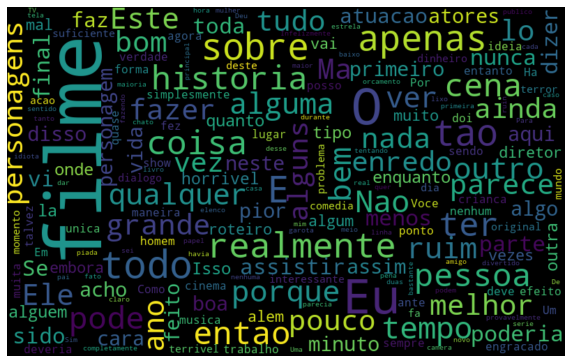

In [34]:
nuvem_palavras_neg(resenha, 'tratamento_3')

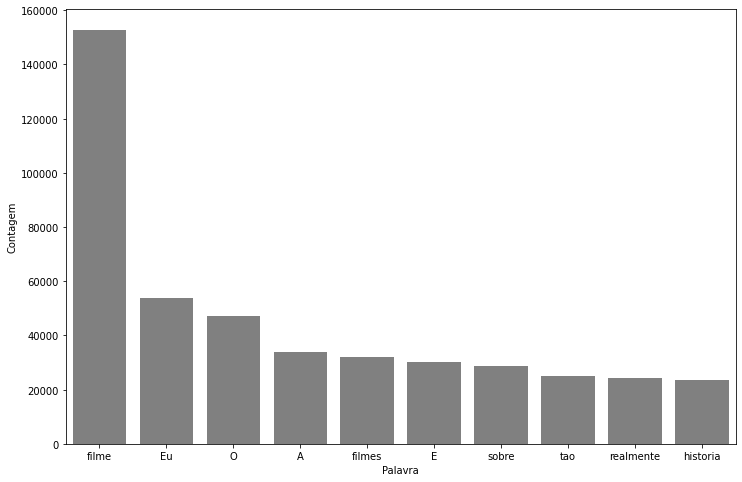

In [35]:
pareto(resenha, 'tratamento_3', 10)

In [36]:
frase_processada = list()
for opiniao in resenha['tratamento_3']:
  nova_frase = list()
  opiniao = opiniao.lower()
  palavras_texto = token_pontuacao.tokenize(opiniao)
  for palavra in palavras_texto:
    if palavra not in stopwords_sem_acento:
      nova_frase.append(palavra)
  frase_processada.append(' '.join(nova_frase))

resenha['tratamento_4'] = frase_processada

In [37]:
acuracia_tratamento4 = classificar_texto(resenha, 'tratamento_4', 'classificacao')
print(acuracia_tratamento4)

0.6874241811564901


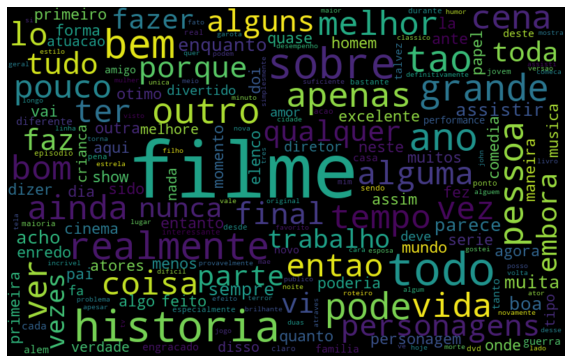

In [38]:
nuvem_palavras_pos(resenha, 'tratamento_4')

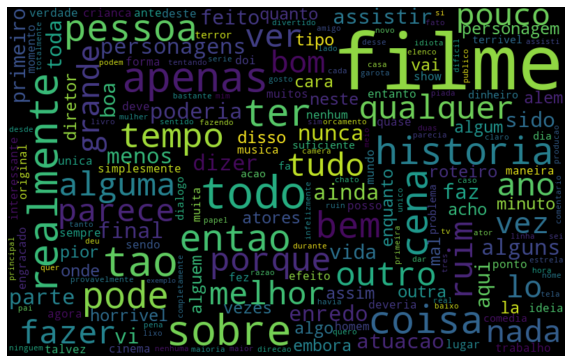

In [39]:
nuvem_palavras_neg(resenha, 'tratamento_4')

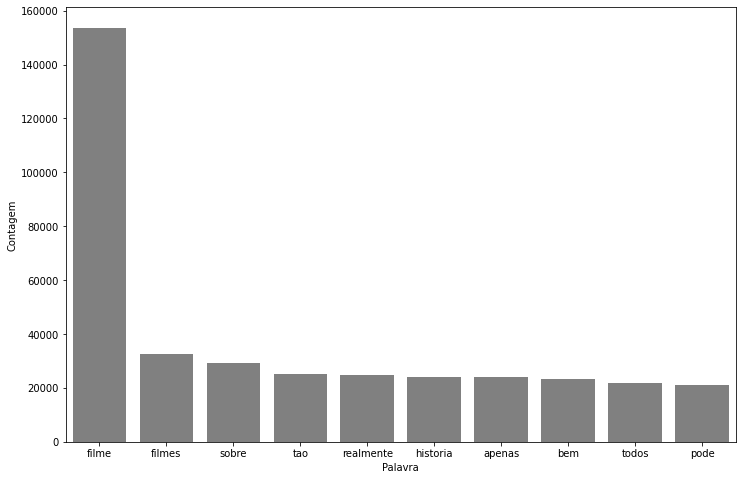

In [40]:
pareto(resenha, 'tratamento_4', 10)

In [46]:
stemmer = nltk.RSLPStemmer()

frase_processada = list()
for opiniao in resenha['tratamento_4']:
  nova_frase = list()
  palavras_texto = token_pontuacao.tokenize(opiniao)
  for palavra in palavras_texto:
    if palavra not in stopwords_sem_acento:
      nova_frase.append(stemmer.stem(palavra))
  frase_processada.append(' '.join(nova_frase))

resenha['tratamento_5'] = frase_processada

In [48]:
acuracia_tratamento5 = classificar_texto(resenha, 'tratamento_5', 'classificacao')
print(acuracia_tratamento5)

0.6954306510311363


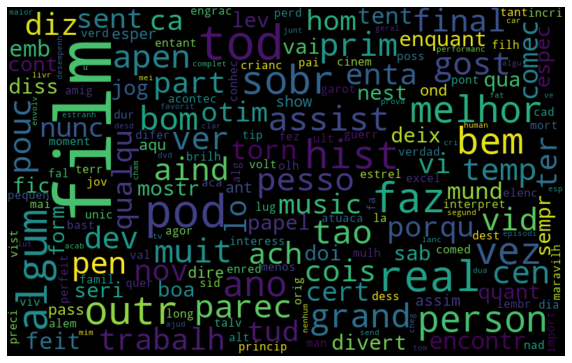

In [49]:
nuvem_palavras_pos(resenha, 'tratamento_5')

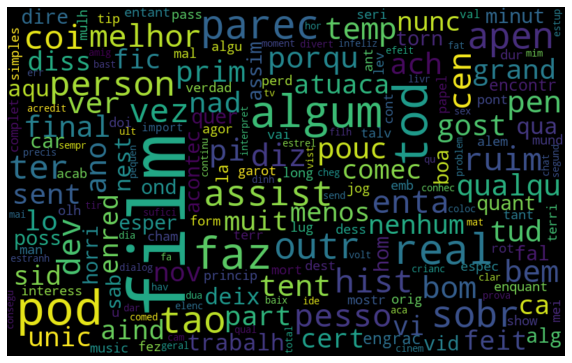

In [50]:
nuvem_palavras_neg(resenha, 'tratamento_5')

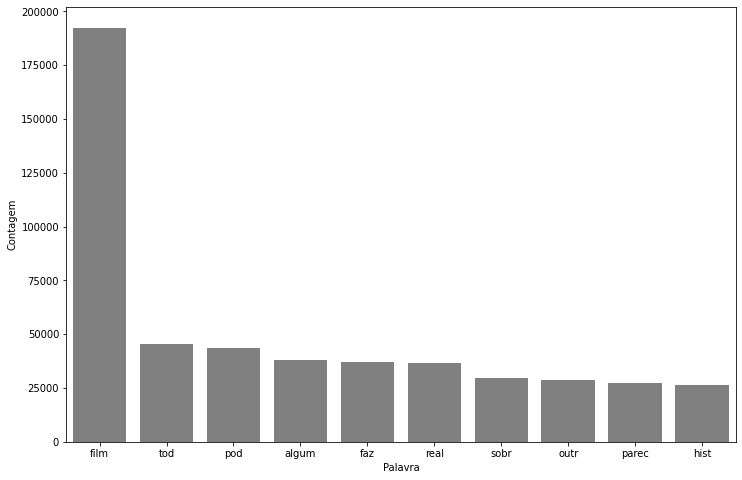

In [51]:
pareto(resenha, 'tratamento_5', 10)

In [53]:
tfidf = TfidfVectorizer(lowercase=False, max_features=50)

In [55]:
#Modelo com tfidf na base original
tfidf_bruto = tfidf.fit_transform(resenha['text_pt'])
treino, teste, classe_treino, classe_teste = train_test_split(tfidf_bruto, resenha['classificacao'], random_state=42)
regressao_logistica = LogisticRegression(solver='lbfgs')
regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf_bruto = regressao_logistica.score(teste, classe_teste)
print(acuracia_tfidf_bruto)

0.6600889607763849


In [56]:
#Modelo com tfidf na base tratada
tfidf_tratado = tfidf.fit_transform(resenha['tratamento_5'])
treino, teste, classe_treino, classe_teste = train_test_split(tfidf_tratado, resenha['classificacao'], random_state=42)
regressao_logistica = LogisticRegression(solver='lbfgs')
regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf_tratado = regressao_logistica.score(teste, classe_teste)
print(acuracia_tfidf_tratado)

0.6963202587949858


In [60]:
#Modelo sem ngrams
tfidf = TfidfVectorizer(lowercase=False)
vetor_tfidf = tfidf.fit_transform(resenha['tratamento_5'])
treino, teste, classe_treino, classe_teste = train_test_split(vetor_tfidf, resenha['classificacao'], random_state=42)
regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf = regressao_logistica.score(teste, classe_teste)
print(acuracia_tfidf)

0.8847553578649414


In [ ]:
#Modelo usando ngrams
tfidf = TfidfVectorizer(lowercase=False, ngram_range=(1,2))
vetor_tfidf = tfidf.fit_transform(resenha['tratamento_5'])
treino, teste, classe_treino, classe_teste = train_test_split(vetor_tfidf, resenha['classificacao'], random_state=42)
regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf_ngrams = regressao_logistica.score(teste, classe_teste)
print(acuracia_tfidf_ngrams)

In [67]:
pesos = pd.DataFrame(
    regressao_logistica.coef_[0].T,
    index = tfidf.get_feature_names()
)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [69]:
pesos.nlargest(50,0)

,0
otim,9.905861
excel,9.008890
perfeit,6.899348
maravilh,6.287748
favorit,5.890854
incri,5.762413
divert,5.386765
brilh,4.857927
ador,4.575856
hoj,4.492844


In [71]:
pesos.nsmallest(50,0)

,0
ruim,-11.783101
pi,-11.462566
horri,-9.725877
terri,-8.404179
nad,-7.623785
chat,-7.517419
parec,-6.881806
nenhum,-6.380778
tent,-5.955765
mal,-5.712541
